# Understanding customers

In [1]:
# Import dependencies

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, silhouette_score

from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Load data

In [2]:
# Load data
df = pd.read_csv('Mall_Customers.csv',index_col=0)

print('Data:')
print(df.head(), end='\n\n')

# Preprocess data

# check if there are missing values
print(df.isnull().sum(), end='\n\n')

# check if there are non-numerical features
print(df.info())

# rename misnamed feature and encode it
df = df.rename(columns={'Genre': 'Gender'})
df['Gender'] = LabelEncoder().fit_transform(df['Gender'])

Data:
             Genre  Age  Annual Income (k$)  Spending Score (1-100)
CustomerID                                                         
1             Male   19                  15                      39
2             Male   21                  15                      81
3           Female   20                  16                       6
4           Female   23                  16                      77
5           Female   31                  17                      40

Genre                     0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 1 to 200
Data columns (total 4 columns):
Genre                     200 non-null object
Age                       200 non-null int64
Annual Income (k$)        200 non-null int64
Spending Score (1-100)    200 non-null int64
dtypes: int64(3), object(1)
memory usage: 7.8+ KB
None


## Preprocessing

As part of the preprocessing we are also going to do some feature selection. Not all features will have equal impact on the outcome variable, and some will have no impact at all. It is better to train your model with only significant features, both to lower runtime and improve results. We will plot our data to see which feature best lets us group costumers aside from the variable we are most interested in, which is spending.

([<matplotlib.axis.XTick at 0x1a228cf630>,
 <a list of 2 Text xticklabel objects>)

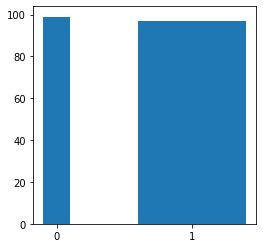

In [3]:
# explore the binary independent feature (Gender)

plt.figure(figsize=(4, 4))
plt.bar(df['Gender'], df['Spending Score (1-100)'], width=0.8)
plt.xticks([0,1])

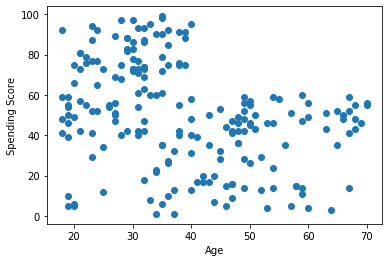

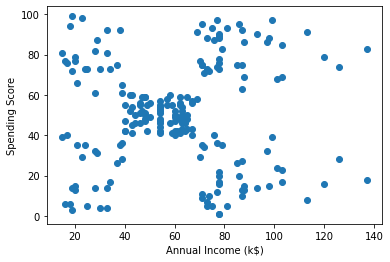

In [4]:
# explore the continuous independent features (Age and Annual Income)

for f in df.columns[1:-1]:
  plt.scatter(df[f], df['Spending Score (1-100)'])
  plt.xlabel(f)
  plt.ylabel('Spending Score')
  plt.show()

The Annual Income feature clearly seems to naturally divide the data into 5 clusters. Since these are clusters are quite distinct we will use this feature to perform clustering on.

## Selecting K

In [5]:
# prepare data for training, note that we do not supply y in an unsupervised task (which is why it is called unsupervised).
X = df[['Annual Income (k$)','Spending Score (1-100)']].values.reshape(-1,2)  

print('Data size:')
print(X.shape)

Data size:
(200, 2)


It is clear from the distribution of the data choosing 5 clusters is a likely option for our choice of k.

However, for illustration purposes, we will also show you the so-called Elbow method for choosing a value for K. The Elbow method is commonly used strategy in which the algorithm is run multiple times with increasing values of k. This is then plotted against the sum of squared distances of samples to their closest cluster center (called inertia). The value of k to choose is identified from the resulting plot where there is an 'elbow' in the graph. 

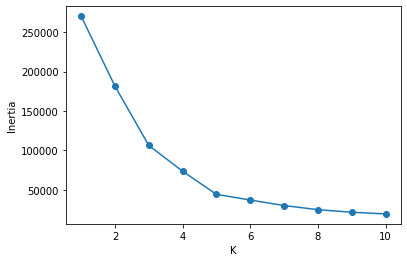

In [6]:
def eval_Kmeans(x, k, r):
    kmeans = KMeans(n_clusters=k, random_state=r)
    kmeans.fit(x)    
    return kmeans.inertia_

def elbow_Kmeans(x, max_k=10, r=123):
    within_cluster_vars = [eval_Kmeans(x, k, r) for k in range(1,max_k+1)]
    plt.plot(range(1,11), within_cluster_vars,marker='o')
    plt.xlabel('K')
    plt.ylabel('Inertia')
    plt.show()

elbow_Kmeans(X)


The elbow runs from k=3 to k=5. In cases like this, it is not always clear which value within the elbow is the most optimal, so we can investigate likely candidates further using the silhouette score. 

## Visualising the outcome 

Let's illustrate the differences with a scatter plot. Note how the silhouette score increases considerably between K=4 and K=5, but not between K=5 and K=6.

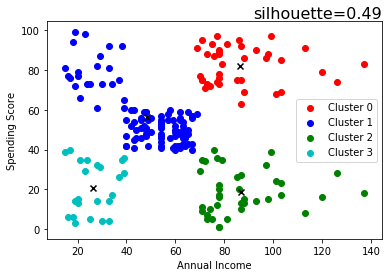

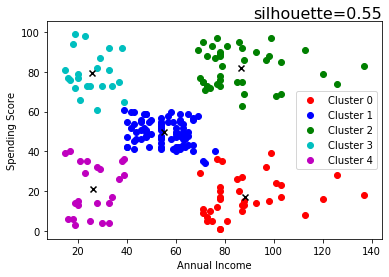

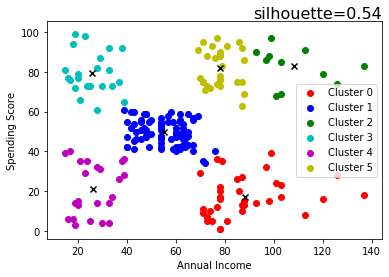

In [7]:
def scatter_Kmeans(x, k, r=123):
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=r)
    y_pred = kmeans.fit_predict(x)
    colours = 'rbgcmy'
    for c in range(k):
      plt.scatter(x[y_pred == c, 0], x[y_pred == c,1], c = colours[c], label = 'Cluster {}'.format(c))
      plt.scatter(kmeans.cluster_centers_[c, 0], kmeans.cluster_centers_[c, 1], marker='x', c = 'black')
    
    score = round(silhouette_score(X, kmeans.labels_, metric='euclidean'),2)
    plt.title('silhouette={}'.format(score), loc='right', fontdict={'fontsize': 16}, pad=-14)
    plt.xlabel('Annual Income')
    plt.ylabel('Spending Score')
    plt.legend()
    plt.show()

for k in range(4,7):
  scatter_Kmeans(X, k, r=0)
  

Thus we see that the best silhouette score is actually achieved using k=5.